In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

import re
import seaborn as sns
import datetime
from datetime import timedelta

Load data.

- Station Data
- Cleaned data of bike trips
- Cleaned data of YVR weather data

In [2]:
data_folder = 'data'
pickle_folder = 'pickle'

#load station data
station_info_df = pd.read_csv(data_folder + '/' + 'station_data.csv', dtype={'id': str, 'name': str, 'lat': float, 'lon': float, 'total_slots':int})

def load_pickle(url):
    '''
    Function to load pickle file
    '''
    infile = open(url, 'rb')
    data = pickle.load(infile)
    infile.close()
    return data

filename = 'mobi_cleaned.pkl'
combined_df = load_pickle(pickle_folder + '/' + filename)

filename = 'YVR_wxdata.pkl'
weather_df = load_pickle(pickle_folder + '/' + filename)   

###  Start of DF assembly

In [3]:
date_range_ind = pd.date_range(start=datetime.date(2017, 1, 1), end=datetime.date(2019, 3, 31), freq='D')

In [4]:
def average_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).sum()/target_df.resample(time_freq).count()
    
    return(output_target_df)


def max_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).max()
       
    return(output_target_df)


def min_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).min()

    return(output_target_df)


def sum_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).sum()
    return(output_target_df)


In [5]:
df = pd.DataFrame({'count': [1] * len(combined_df['Departure'])})
df.index = combined_df['Departure']

df = df.resample('D').count()
#df['AVG_TEMP'] = temp_daily_avg_df
df = df[:-1]


var_list = ['CO', 'NO', 'NO2', 'O3', 'PM25', 'SO2', 'PM10', 'WSPD_SCLR',
       'WDIR_SCLR', 'WSPD_VECT', 'WDIR_VECT', 'TEMP_MEAN', 'ATM_PRESS_1HR',
       'HUMIDITY', 'RAD_TOTAL', 'PRECIP_TOTAL']


for var in var_list:
    df[('AVG_'+var)] = average_df(var, weather_df)

for var in ['TEMP_MEAN']:
    df[('MAX_'+var)] = max_df(var, weather_df)
    
for var in ['TEMP_MEAN']:
    df[('MIN_'+var)] = min_df(var, weather_df)

for var in ['TEMP_MEAN']:
    df[('RANGE_'+var)] = max_df(var, weather_df) - min_df(var, weather_df) 

    
df['SUM_PRECIP_TOTAL'] = sum_df('PRECIP_TOTAL', weather_df)

### Plotting the Correlation Matrix

First scale the data before doing the correlation matrix, or else it will be skewed.

The variables that are highly correlated to the trip counts in a day is the average temperature and the average solar irradiance. There is a theoretical equation in which the total and average solar irradiance can be calcuated, but this variables fluctuates with cloud cover and aerosol concentration in the air. 

From a practical perspective, temperature and precipitation are the only variables where we can reasonable rely on if we want to use forecast data from a weather model. 

For this project, I am going to make an assumption that the observation model that we use for the testing and validation are the same as the forecast data that is generated from a weather model. Usually, the data from a weather model that are 2-3 days out are quite reliable.

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


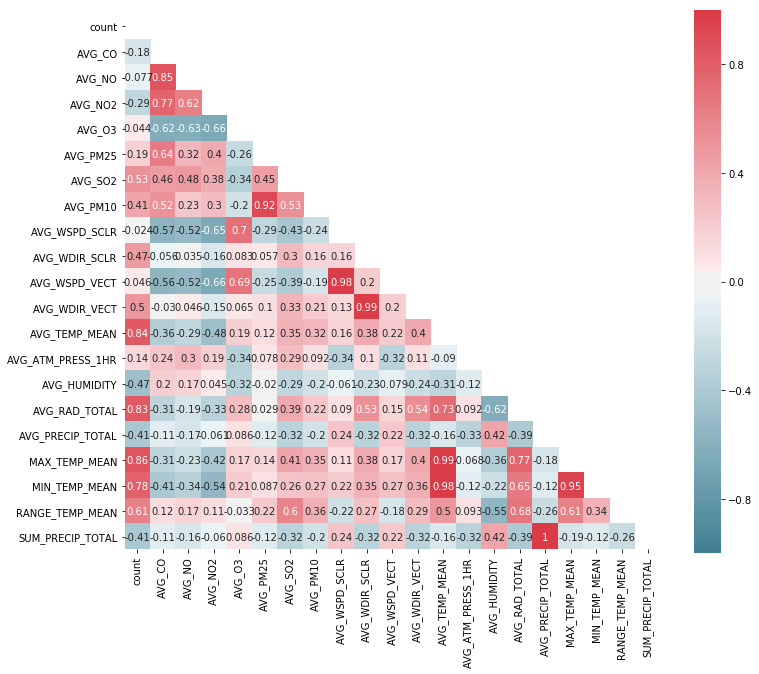

In [6]:
from sklearn.preprocessing import StandardScaler

def scale_data(df):
    scaler = StandardScaler()
    scaler.fit(df)
    scaled_df = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns, index=df.index)
    return(scaled_df)

#scaled_df = scale_data(df)

plt.figure(figsize=(12,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#cmap = sns.color_palette("coolwarm", 100)

corr_df = scale_data(df).corr()

mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_df, mask = mask, annot=True, cmap=cmap, center=0, vmin=-1.0, vmax=1.0, square=True);

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


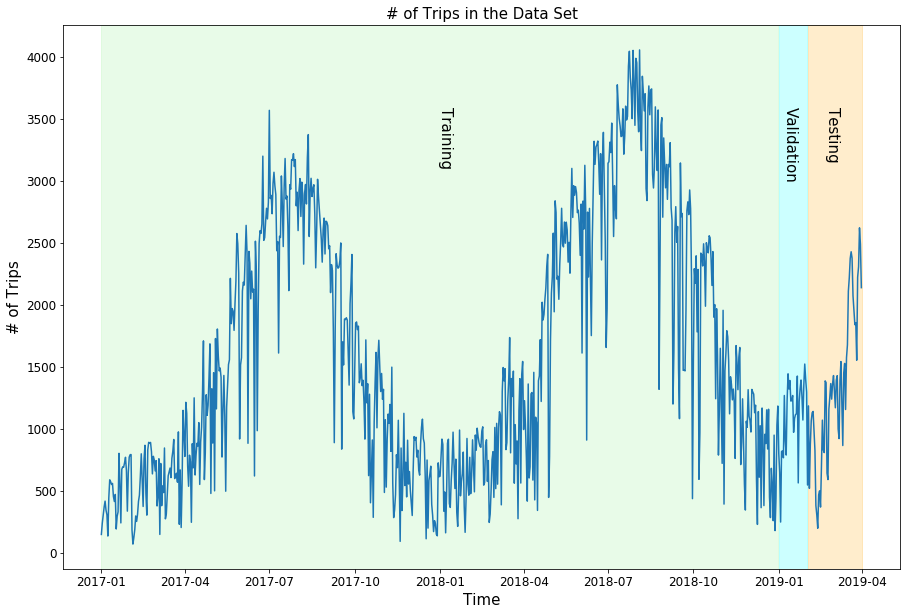

In [7]:
col = 'black'
a = 0.2
font_size_tick=12
plt.figure(figsize=(15,10))
plt.plot(df['count'], label='Count')
plt.xlabel('Time', fontsize=15, color=col)
plt.ylabel('# of Trips', fontsize=15, color=col)
plt.title('# of Trips in the Data Set',  fontsize=15, color=col)
plt.xticks(fontsize=font_size_tick, color=col)
plt.yticks(fontsize=font_size_tick, color=col)
plt.axvspan('2017-01-01', '2018-12-31', color='lightgreen', alpha=a)
plt.axvspan('2019-01-01', '2019-01-31', color='cyan', alpha=a)
plt.axvspan('2019-02-01', '2019-04-01', color='orange', alpha=a)
plt.annotate('Training', ('2017-12-30', 3500), fontsize=15, rotation=270)
plt.annotate('Validation', ('2019-01-05', 3500), fontsize=15, rotation=270)
plt.annotate('Testing', ('2019-02-20', 3500), fontsize=15, rotation=270)
plt.show();

### Adding Additional Features

#### Day of the Week

In [8]:
df['day_of_week']=df.index.to_series().dt.dayofweek

df.loc[df['day_of_week'] == 0, 'day_of_week'] = 'Monday'
df.loc[df['day_of_week'] == 1, 'day_of_week'] = 'Tuesday'
df.loc[df['day_of_week'] == 2, 'day_of_week'] = 'Wednesday'
df.loc[df['day_of_week'] == 3, 'day_of_week'] = 'Thursday'
df.loc[df['day_of_week'] == 4, 'day_of_week'] = 'Friday'
df.loc[df['day_of_week'] == 5, 'day_of_week'] = 'Saturday'
df.loc[df['day_of_week'] == 6, 'day_of_week'] = 'Sunday'

#### Holidays in BC

In [9]:
holiday_list = [datetime.datetime(2017, 1, 1),
    datetime.datetime(2017, 1, 2),
    datetime.datetime(2017, 2, 13),
    datetime.datetime(2017, 4, 14),
    datetime.datetime(2017, 5, 22),
    datetime.datetime(2017, 7, 1),
    datetime.datetime(2017, 8, 7),
    datetime.datetime(2017, 9, 4),
    datetime.datetime(2017, 10, 9),
    datetime.datetime(2017, 11, 10),
    datetime.datetime(2017, 11, 11),
    datetime.datetime(2017, 12, 24),
    datetime.datetime(2017, 12, 25),
    datetime.datetime(2017, 12, 26),
    datetime.datetime(2018, 1, 1),
    datetime.datetime(2018, 2, 12),
    datetime.datetime(2018, 3, 30),
    datetime.datetime(2018, 5, 21),
    datetime.datetime(2018, 7, 1),
    datetime.datetime(2018, 7, 2),
    datetime.datetime(2018, 8, 6),
    datetime.datetime(2018, 9, 3),
    datetime.datetime(2018, 10, 8),
    datetime.datetime(2018, 11, 11),
    datetime.datetime(2018, 11, 12),
    datetime.datetime(2018, 12, 24),
    datetime.datetime(2018, 12, 25),
    datetime.datetime(2018, 12, 26),
    datetime.datetime(2019, 1, 1),
    datetime.datetime(2019, 2, 18)
]
holiday_list = pd.to_datetime(holiday_list)

#convert to 1 and 0
holiday_col = date_range_ind.isin(holiday_list)

df['HOLIDAY'] = holiday_col.astype(int)
df['NOT_HOLIDAY'] = (~(holiday_col)).astype(int)

del holiday_list, holiday_col

#### Add Season

In [10]:
#from stack overflow
#https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime

def season_of_date(date):
    year = str(date.year)
    seasons = {'Spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'Summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'Autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['Spring']:
        return 'Spring'
    if date in seasons['Summer']:
        return 'Summer'
    if date in seasons['Autumn']:
        return 'Autumn'
    else:
        return 'Winter'
    
df['SEASON'] = date_range_ind.map(season_of_date)

#### Add Quarter, Weekday, Weekend


In [11]:
df['QUARTER'] = date_range_ind.quarter.astype(str)

df['Weekday'] = df['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype(int)
df['Weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

#### Functions for model analysis 

In [12]:
def custom_predict(model, X_train, X_valid, X_test, y_scaler=None):
    '''
    Uses the predict method for a model on the train valid and test set.
    '''
    
    X_list = [X_train, X_valid, X_test]

    y_pred_list = []
    
    for i in range(0,3):
        
        y_pred = model.predict(X_list[i])
        
        #For Neural networks
        if y_scaler is not None:
            y_pred = y_scaler.inverse_transform(y_pred)
        
        y_pred_list.append(y_pred)
            
    return y_pred_list

def custom_model_score(y_pred_list, y_train, y_valid, y_test):
    '''
    Calculates the RMSE and R2 metrics
    '''
    
    import math
    from sklearn.metrics import r2_score, mean_squared_error
    
   
    score_output = [
        math.sqrt(mean_squared_error(y_train, y_pred_list[0].round())),
        math.sqrt(mean_squared_error(y_valid, y_pred_list[1].round())),
        math.sqrt(mean_squared_error(y_test, y_pred_list[2].round())),
        r2_score(y_train, y_pred_list[0].round()),
        r2_score(y_valid, y_pred_list[1].round()),
        r2_score(y_test, y_pred_list[2].round())
        ]
    
    return (score_output)

def custom_score_display(the_score, index=None):
    
    '''
    If a list of index is provided, it will expect the first argument to be a list to create a combined score.
    '''

    if index is None:
        output_score  = pd.DataFrame([the_score])
    else:
        output_score = pd.DataFrame(the_score)
        output_score.index = index
    
    output_score.columns = ['Training - RMSE', 'Validation - RMSE', 'Test - RMSE', 'Training - R2', 'Valid - R2', 'Test - R2']
    
    return (output_score)

def custom_plot_package(model_name, y_pred_list, y_train, y_valid, y_test):

    '''
    Outputs plots for train, valid, and test
    
    In addition, it calls the model_score function that calculates the RMSE and R2
    '''
    
    plt.figure(figsize=(10,10))

    
    name_list = ['Training', 'Validation', 'Test']
    y_list = [y_train, y_valid, y_test]
    
    for i in range(3):
        plt.subplot(3,1, (i + 1))
        plt.plot(y_list[i], label='Actual')
        plt.plot(pd.DataFrame(y_pred_list[i], index=y_list[i].index), label='Prediction')
        plt.legend()
        plt.title(model_name + ' - ' + name_list[i])
        plt.xlim(y_list[i].index[0], y_list[i].index[-1])

    return None

### Assemble DataFrame

In [13]:
X = df.reindex(['AVG_TEMP_MEAN', 'day_of_week', 'SUM_PRECIP_TOTAL', 'MAX_TEMP_MEAN', 'MIN_TEMP_MEAN',
                'HOLIDAY', 'NOT_HOLIDAY', 'SEASON', 'QUARTER', 'Weekday', 'Weekend'], axis=1)

y = df['count']

In [14]:
date_range_train = pd.date_range(start=datetime.date(2017, 1, 1), end=datetime.date(2018, 12, 31), freq='D')
date_range_valid = pd.date_range(start=datetime.date(2019, 1, 1), end=datetime.date(2019, 1, 31), freq='D')
date_range_test = pd.date_range(start=datetime.date(2019, 2, 1), end=datetime.date(2019, 3, 31), freq='D')

X_onehot = pd.get_dummies(X)

X_train = X_onehot.loc[date_range_train]
X_valid = X_onehot.loc[date_range_valid]
X_test = X_onehot.loc[date_range_test]

y_train = y.loc[date_range_train]
y_valid = y.loc[date_range_valid]
y_test = y.loc[date_range_test]

#For Statsmodel OLS
import statsmodels.api as sm
X_onehot_c = sm.add_constant(X_onehot)

X_train_c = X_onehot_c.loc[date_range_train]
X_test_c = X_onehot_c.loc[date_range_test]
X_valid_c = X_onehot_c.loc[date_range_valid]

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [15]:
from statsmodels.regression import linear_model

lin_reg_model_sm = linear_model.OLS(y_train, X_train_c).fit()
lin_reg_model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     230.7
Date:                Fri, 30 Aug 2019   Prob (F-statistic):          7.51e-276
Time:                        14:02:46   Log-Likelihood:                -5418.3
No. Observations:                 730   AIC:                         1.087e+04
Df Residuals:                     712   BIC:                         1.096e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    89.3768     27.679      3.229      0.001      35.034     143.719
AVG_TEMP_MEAN           160.2056     45.364      3.532      0.000      71.142     249.269
SUM_PRECIP_TOTAL        -30.2747      2.159    -14.022      0.000     -34.513     -26.036
MAX_TEMP_MEAN            51.9079     24.315      2.135      0.033       4.170      99.646
MIN_TEMP_MEAN          -123.3256     23.920     -5.156      0.000    -170.288     -76.364
HOLIDAY                  17.5973     50.072      0.351      0.725     -80.710     115.904
NOT_HOLIDAY              71.7795     37.284      1.925      0.055      -1.421     144.980
Weekday                 104.2826     19.296      5.404      0.000      66.399     142.166
Weekend                 -14.9057     17.968     -0.830      0.407     -50.183      20.371
day_of_week_Friday       50.6270     36.198      1.399      0.162     -20.440     121.694
day_of_week_Monday      -35.5753     36.891     -0.964      0.335    -108.003      36.852
day_of_week_Saturday     72.4028     29.772      2.432      0.015      13.952     130.854
day_of_week_Sunday      -87.3085     29.813     -2.929      0.004    -145.840     -28.777
day_of_week_Thursday     53.8860     36.646      1.470      0.142     -18.062     125.834
day_of_week_Tuesday      30.6977     36.436      0.843      0.400     -40.837     102.233
day_of_week_Wednesday     4.6472     36.382      0.128      0.898     -66.782      76.076
SEASON_Autumn             7.9719     57.795      0.138      0.890    -105.497     121.441
SEASON_Spring          -141.6792     53.857     -2.631      0.009    -247.417     -35.942
SEASON_Summer           331.6684     62.950      5.269      0.000     208.079     455.258
SEASON_Winter          -108.5842     55.525     -1.956      0.051    -217.597       0.428
QUARTER_1              -111.2705     54.350     -2.047      0.041    -217.976      -4.565
QUARTER_2               100.4451     57.371      1.751      0.080     -12.191     213.081
QUARTER_3               104.8765     60.937      1.721      0.086     -14.762     224.515
QUARTER_4                -4.6743     57.580     -0.081      0.935    -117.720     108.372
==============================================================================
Omnibus:                        2.327   Durbin-Watson:                   0.876
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                2.309
Skew:                           0.138   Prob(JB):                        0.315
Kurtosis:                       2.983   Cond. No.                     5.21e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.34e-30. This might indicate that there are


,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,404.757259,421.274793,558.745766,0.846386,-1.003925,0.175153


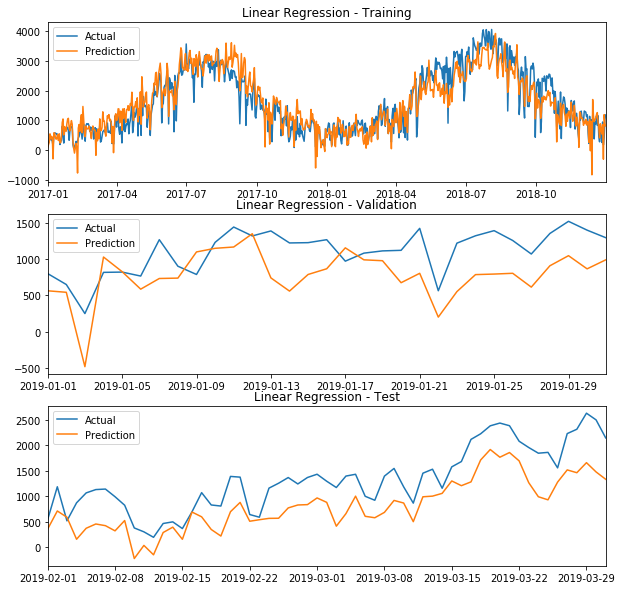

In [16]:
lin_y_pred_list = custom_predict(lin_reg_model_sm, X_train_c, X_valid_c, X_test_c, y_scaler=None)
y_pred_list = lin_y_pred_list
lin_score = custom_model_score(y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(lin_score))
custom_plot_package('Linear Regression', y_pred_list, y_train, y_valid, y_test)

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor

#RF_model =  RandomForestRegressor(n_estimators=50, max_depth = 4, oob_score=True, min_samples_leaf=5)
RF_model = RandomForestRegressor(n_estimators=50, max_depth=10, oob_score=False, n_jobs=-1)
RF_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,184.936772,397.622329,487.757633,0.967931,-0.785221,0.371431


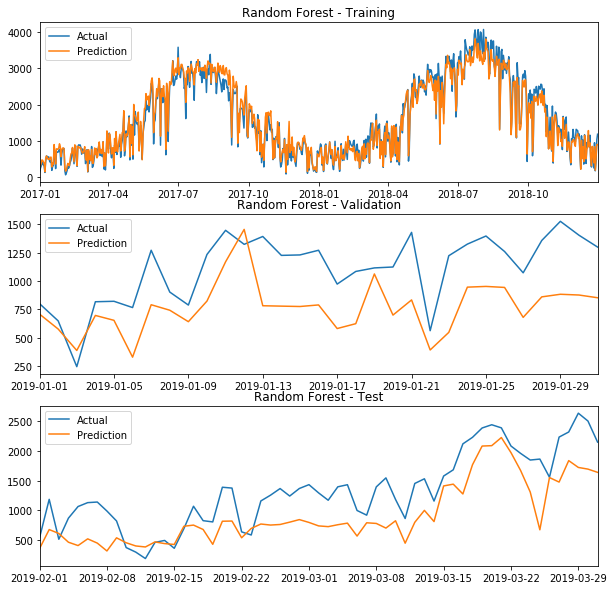

In [18]:
RF_y_pred_list = custom_predict(RF_model, X_train, X_valid, X_test, y_scaler=None)
y_pred_list = RF_y_pred_list
RF_score = custom_model_score(y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(RF_score))
custom_plot_package('Random Forest', y_pred_list, y_train, y_valid, y_test)

### XGBoost

In [19]:
from xgboost import XGBRegressor

XGB_model = XGBRegressor(learning_rate=.05, max_depth=4, 
                             n_estimators=200, gamma=0, 
                             subsample=0.9, colsample_bytree=0.7,
                             scale_pos_weight=1, min_child_weight=3,
                             reg_alpha=0.01)
XGB_model.fit(X_train, y_train)

[14:02:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=3, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,236.069992,377.174598,493.899273,0.947746,-0.606332,0.355502


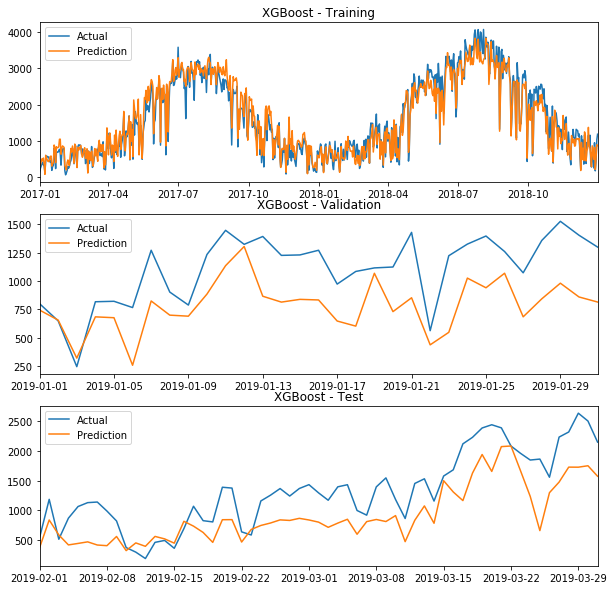

In [20]:
XGB_y_pred_list = custom_predict(XGB_model, X_train, X_valid, X_test, y_scaler=None)
y_pred_list = XGB_y_pred_list
XGB_score = custom_model_score(y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(XGB_score))
custom_plot_package('XGBoost', y_pred_list, y_train, y_valid, y_test)

### LightGBM

In [21]:
from lightgbm import LGBMRegressor

LGBM_model = LGBMRegressor(learning_rate=0.1,
                           max_depth=3, 
                           n_estimators=302, 
                           num_leaves=6,
                           reg_alpha=94,
                           reg_lambda=92
                          )
LGBM_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=3,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=302, n_jobs=-1, num_leaves=6, objective=None,
       random_state=None, reg_alpha=94, reg_lambda=92, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,302.574415,386.498466,473.081048,0.914157,-0.686732,0.408689


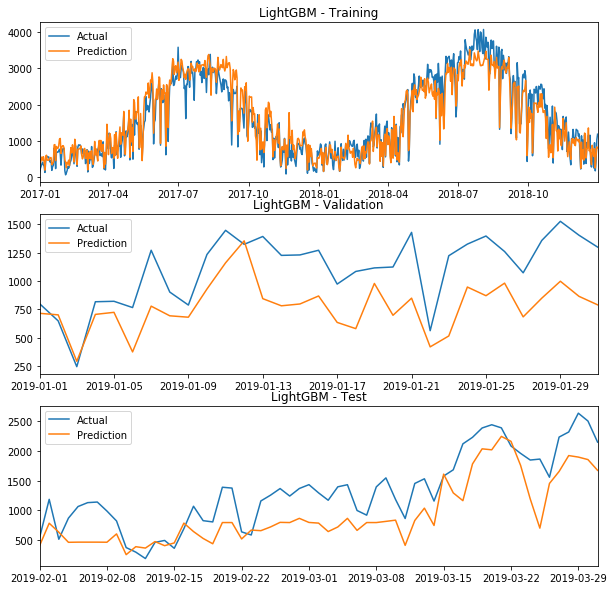

In [22]:
LGBM_y_pred_list = custom_predict(LGBM_model, X_train, X_valid, X_test, y_scaler=None)
y_pred_list = LGBM_y_pred_list
LGBM_score = custom_model_score(y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(LGBM_score))
custom_plot_package('LightGBM', y_pred_list, y_train, y_valid, y_test)

### CatBoost

In [23]:
from catboost import CatBoostRegressor
CB_model = CatBoostRegressor(learning_rate=0.01, 
                             max_depth=6, 
                             n_estimators=1500, 
                             l2_leaf_reg=4,
                             random_strength=0,
                             bagging_temperature=40,
                             task_type='GPU')

CB_model.fit(X_train, y_train)

0:	learn: 1904.2029591	total: 9.91ms	remaining: 14.9s
1:	learn: 1889.1047615	total: 19.7ms	remaining: 14.8s
2:	learn: 1874.1858214	total: 29.7ms	remaining: 14.8s
3:	learn: 1859.4447956	total: 37.8ms	remaining: 14.1s
4:	learn: 1844.8798662	total: 45.3ms	remaining: 13.6s
5:	learn: 1830.4895849	total: 52.9ms	remaining: 13.2s
6:	learn: 1816.2721177	total: 60.8ms	remaining: 13s
7:	learn: 1802.2259114	total: 68.8ms	remaining: 12.8s
8:	learn: 1788.3493147	total: 77.1ms	remaining: 12.8s
9:	learn: 1774.6410696	total: 85.2ms	remaining: 12.7s
10:	learn: 1759.0678478	total: 95.3ms	remaining: 12.9s
11:	learn: 1745.6681729	total: 103ms	remaining: 12.8s
12:	learn: 1732.4320635	total: 111ms	remaining: 12.8s
13:	learn: 1719.3575863	total: 119ms	remaining: 12.7s
14:	learn: 1706.4436270	total: 128ms	remaining: 12.6s
15:	learn: 1693.6885256	total: 138ms	remaining: 12.8s
16:	learn: 1681.0909439	total: 152ms	remaining: 13.2s
17:	learn: 1668.6490902	total: 164ms	remaining: 13.5s
18:	learn: 1656.3619219	total

156:	learn: 866.4731726	total: 1.48s	remaining: 12.7s
157:	learn: 864.9872594	total: 1.49s	remaining: 12.7s
158:	learn: 860.6408062	total: 1.5s	remaining: 12.7s
159:	learn: 859.2017959	total: 1.51s	remaining: 12.7s
160:	learn: 857.7888363	total: 1.52s	remaining: 12.7s
161:	learn: 856.4014933	total: 1.53s	remaining: 12.7s
162:	learn: 855.0392765	total: 1.54s	remaining: 12.7s
163:	learn: 853.7017413	total: 1.56s	remaining: 12.7s
164:	learn: 850.0974577	total: 1.57s	remaining: 12.7s
165:	learn: 848.8024634	total: 1.58s	remaining: 12.7s
166:	learn: 847.5310670	total: 1.58s	remaining: 12.7s
167:	learn: 846.2828829	total: 1.59s	remaining: 12.6s
168:	learn: 841.6698862	total: 1.6s	remaining: 12.6s
169:	learn: 840.4637989	total: 1.61s	remaining: 12.6s
170:	learn: 839.2798217	total: 1.62s	remaining: 12.6s
171:	learn: 838.1174992	total: 1.63s	remaining: 12.6s
172:	learn: 836.9765549	total: 1.64s	remaining: 12.6s
173:	learn: 835.8566043	total: 1.65s	remaining: 12.6s
174:	learn: 834.7572332	total:

328:	learn: 699.5033855	total: 3.13s	remaining: 11.1s
329:	learn: 699.4479545	total: 3.14s	remaining: 11.1s
330:	learn: 695.8234385	total: 3.15s	remaining: 11.1s
331:	learn: 695.4771142	total: 3.16s	remaining: 11.1s
332:	learn: 695.4248923	total: 3.17s	remaining: 11.1s
333:	learn: 695.3736750	total: 3.18s	remaining: 11.1s
334:	learn: 694.6951081	total: 3.19s	remaining: 11.1s
335:	learn: 694.6458248	total: 3.19s	remaining: 11.1s
336:	learn: 694.2713851	total: 3.2s	remaining: 11.1s
337:	learn: 692.4084629	total: 3.21s	remaining: 11s
338:	learn: 691.6297370	total: 3.22s	remaining: 11s
339:	learn: 691.5839750	total: 3.23s	remaining: 11s
340:	learn: 691.2824532	total: 3.24s	remaining: 11s
341:	learn: 690.7997827	total: 3.25s	remaining: 11s
342:	learn: 690.4024953	total: 3.26s	remaining: 11s
343:	learn: 690.3602395	total: 3.27s	remaining: 11s
344:	learn: 690.3188066	total: 3.28s	remaining: 11s
345:	learn: 690.2782286	total: 3.29s	remaining: 11s
346:	learn: 690.2384103	total: 3.3s	remaining: 

492:	learn: 637.0891338	total: 4.75s	remaining: 9.71s
493:	learn: 637.0826316	total: 4.76s	remaining: 9.7s
494:	learn: 635.2650186	total: 4.78s	remaining: 9.7s
495:	learn: 635.2583942	total: 4.79s	remaining: 9.7s
496:	learn: 635.1630230	total: 4.8s	remaining: 9.69s
497:	learn: 635.1564320	total: 4.81s	remaining: 9.68s
498:	learn: 635.1499791	total: 4.82s	remaining: 9.67s
499:	learn: 634.8719901	total: 4.83s	remaining: 9.66s
500:	learn: 634.8657069	total: 4.84s	remaining: 9.65s
501:	learn: 634.8595616	total: 4.85s	remaining: 9.64s
502:	learn: 634.7817401	total: 4.86s	remaining: 9.63s
503:	learn: 634.7758357	total: 4.87s	remaining: 9.61s
504:	learn: 634.7700004	total: 4.87s	remaining: 9.6s
505:	learn: 634.6933420	total: 4.88s	remaining: 9.59s
506:	learn: 634.6877476	total: 4.89s	remaining: 9.58s
507:	learn: 634.6823604	total: 4.9s	remaining: 9.56s
508:	learn: 634.6770422	total: 4.91s	remaining: 9.55s
509:	learn: 634.6717931	total: 4.92s	remaining: 9.54s
510:	learn: 634.6666820	total: 4.9

651:	learn: 596.0837672	total: 6.4s	remaining: 8.33s
652:	learn: 596.0400832	total: 6.41s	remaining: 8.32s
653:	learn: 596.0348799	total: 6.42s	remaining: 8.31s
654:	learn: 596.0297501	total: 6.44s	remaining: 8.3s
655:	learn: 596.0247122	total: 6.45s	remaining: 8.29s
656:	learn: 596.0197845	total: 6.46s	remaining: 8.28s
657:	learn: 595.9577626	total: 6.46s	remaining: 8.27s
658:	learn: 595.9151176	total: 6.47s	remaining: 8.26s
659:	learn: 595.9103178	total: 6.48s	remaining: 8.25s
660:	learn: 595.9056283	total: 6.49s	remaining: 8.23s
661:	learn: 595.9010123	total: 6.5s	remaining: 8.22s
662:	learn: 595.8964882	total: 6.5s	remaining: 8.21s
663:	learn: 595.8920561	total: 6.51s	remaining: 8.2s
664:	learn: 595.8398240	total: 6.52s	remaining: 8.19s
665:	learn: 595.8355202	total: 6.53s	remaining: 8.18s
666:	learn: 595.4267354	total: 6.54s	remaining: 8.16s
667:	learn: 595.3778126	total: 6.55s	remaining: 8.15s
668:	learn: 595.3367276	total: 6.56s	remaining: 8.14s
669:	learn: 595.3323096	total: 6.

820:	learn: 565.8522001	total: 8.05s	remaining: 6.66s
821:	learn: 564.9874577	total: 8.06s	remaining: 6.65s
822:	learn: 564.9433091	total: 8.07s	remaining: 6.64s
823:	learn: 564.9383043	total: 8.08s	remaining: 6.63s
824:	learn: 564.9333771	total: 8.09s	remaining: 6.62s
825:	learn: 564.9104669	total: 8.1s	remaining: 6.61s
826:	learn: 564.9057528	total: 8.1s	remaining: 6.59s
827:	learn: 564.8506555	total: 8.11s	remaining: 6.58s
828:	learn: 564.8460767	total: 8.12s	remaining: 6.57s
829:	learn: 564.8415950	total: 8.13s	remaining: 6.56s
830:	learn: 564.8371519	total: 8.14s	remaining: 6.55s
831:	learn: 564.7863943	total: 8.15s	remaining: 6.54s
832:	learn: 564.7821449	total: 8.15s	remaining: 6.53s
833:	learn: 564.7779537	total: 8.17s	remaining: 6.52s
834:	learn: 564.7561627	total: 8.18s	remaining: 6.51s
835:	learn: 563.0246886	total: 8.19s	remaining: 6.5s
836:	learn: 563.0202313	total: 8.2s	remaining: 6.49s
837:	learn: 563.0158712	total: 8.2s	remaining: 6.48s
838:	learn: 562.1797694	total: 8.

976:	learn: 539.4489324	total: 9.53s	remaining: 5.1s
977:	learn: 539.4414361	total: 9.54s	remaining: 5.09s
978:	learn: 539.0308096	total: 9.55s	remaining: 5.08s
979:	learn: 539.0188956	total: 9.56s	remaining: 5.07s
980:	learn: 538.4032201	total: 9.56s	remaining: 5.06s
981:	learn: 538.3163810	total: 9.57s	remaining: 5.05s
982:	learn: 538.2996263	total: 9.58s	remaining: 5.04s
983:	learn: 538.2933559	total: 9.59s	remaining: 5.03s
984:	learn: 538.2863728	total: 9.6s	remaining: 5.02s
985:	learn: 538.2802041	total: 9.61s	remaining: 5.01s
986:	learn: 537.2000673	total: 9.62s	remaining: 5s
987:	learn: 537.1933557	total: 9.63s	remaining: 4.99s
988:	learn: 537.1867459	total: 9.64s	remaining: 4.98s
989:	learn: 537.0708991	total: 9.65s	remaining: 4.97s
990:	learn: 537.0595334	total: 9.66s	remaining: 4.96s
991:	learn: 537.0435150	total: 9.67s	remaining: 4.95s
992:	learn: 537.0371075	total: 9.68s	remaining: 4.94s
993:	learn: 536.9480065	total: 9.69s	remaining: 4.93s
994:	learn: 536.9415366	total: 9.

1130:	learn: 516.6572431	total: 11.2s	remaining: 3.65s
1131:	learn: 516.2285997	total: 11.2s	remaining: 3.64s
1132:	learn: 516.2266891	total: 11.2s	remaining: 3.63s
1133:	learn: 516.2198321	total: 11.2s	remaining: 3.62s
1134:	learn: 516.2113192	total: 11.2s	remaining: 3.61s
1135:	learn: 515.8686039	total: 11.2s	remaining: 3.6s
1136:	learn: 515.8501428	total: 11.3s	remaining: 3.59s
1137:	learn: 515.8482946	total: 11.3s	remaining: 3.58s
1138:	learn: 515.8420487	total: 11.3s	remaining: 3.58s
1139:	learn: 515.8333383	total: 11.3s	remaining: 3.57s
1140:	learn: 515.6645187	total: 11.3s	remaining: 3.56s
1141:	learn: 515.6584194	total: 11.3s	remaining: 3.55s
1142:	learn: 515.6495996	total: 11.3s	remaining: 3.54s
1143:	learn: 515.6409922	total: 11.3s	remaining: 3.53s
1144:	learn: 515.5972093	total: 11.4s	remaining: 3.52s
1145:	learn: 515.5954239	total: 11.4s	remaining: 3.51s
1146:	learn: 515.5868793	total: 11.4s	remaining: 3.5s
1147:	learn: 515.5649647	total: 11.4s	remaining: 3.49s
1148:	learn:

1297:	learn: 494.5437748	total: 13s	remaining: 2.02s
1298:	learn: 494.5350882	total: 13s	remaining: 2.01s
1299:	learn: 494.4581648	total: 13s	remaining: 2s
1300:	learn: 494.4577658	total: 13s	remaining: 1.99s
1301:	learn: 494.4492328	total: 13s	remaining: 1.98s
1302:	learn: 494.4406553	total: 13s	remaining: 1.97s
1303:	learn: 494.4406332	total: 13.1s	remaining: 1.96s
1304:	learn: 494.4400569	total: 13.1s	remaining: 1.96s
1305:	learn: 494.3925566	total: 13.2s	remaining: 1.96s
1306:	learn: 494.1371115	total: 13.2s	remaining: 1.95s
1307:	learn: 494.1351820	total: 13.2s	remaining: 1.94s
1308:	learn: 494.1020692	total: 13.2s	remaining: 1.93s
1309:	learn: 494.0933083	total: 13.2s	remaining: 1.92s
1310:	learn: 493.9387350	total: 13.2s	remaining: 1.91s
1311:	learn: 493.9298603	total: 13.2s	remaining: 1.9s
1312:	learn: 493.9134859	total: 13.2s	remaining: 1.89s
1313:	learn: 493.8847517	total: 13.2s	remaining: 1.88s
1314:	learn: 493.7329099	total: 13.3s	remaining: 1.86s
1315:	learn: 493.6541299	t

1457:	learn: 481.3765649	total: 14.6s	remaining: 422ms
1458:	learn: 481.3765194	total: 14.7s	remaining: 412ms
1459:	learn: 481.2335292	total: 14.7s	remaining: 402ms
1460:	learn: 480.7715033	total: 14.7s	remaining: 392ms
1461:	learn: 480.6967318	total: 14.7s	remaining: 382ms
1462:	learn: 480.6966634	total: 14.7s	remaining: 372ms
1463:	learn: 480.4337766	total: 14.7s	remaining: 362ms
1464:	learn: 480.4336854	total: 14.7s	remaining: 352ms
1465:	learn: 480.4266141	total: 14.7s	remaining: 342ms
1466:	learn: 480.4161666	total: 14.8s	remaining: 332ms
1467:	learn: 480.4160982	total: 14.8s	remaining: 322ms
1468:	learn: 480.3854617	total: 14.8s	remaining: 312ms
1469:	learn: 480.3852335	total: 14.8s	remaining: 302ms
1470:	learn: 480.3750361	total: 14.8s	remaining: 292ms
1471:	learn: 480.3650438	total: 14.8s	remaining: 282ms
1472:	learn: 480.3552567	total: 14.8s	remaining: 272ms
1473:	learn: 480.3551882	total: 14.8s	remaining: 262ms
1474:	learn: 480.3551426	total: 14.9s	remaining: 252ms
1475:	lear

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,478.56446,262.121124,375.74615,0.785256,0.224192,0.626978


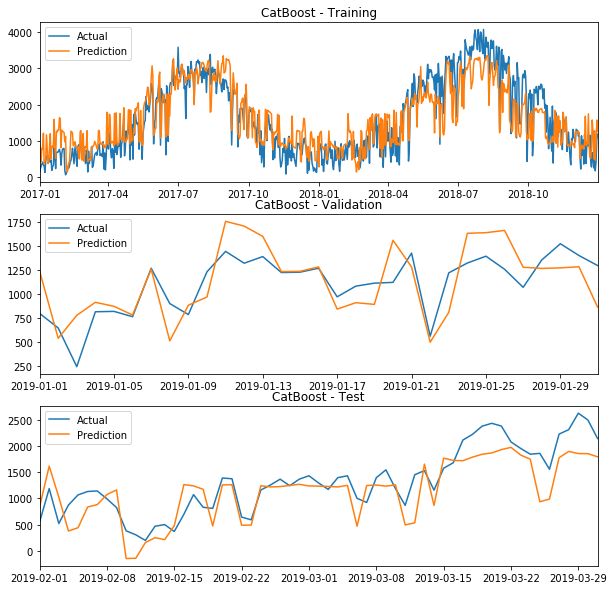

In [24]:
CB_y_pred_list = custom_predict(CB_model, X_train, X_valid, X_test, y_scaler=None)
y_pred_list = CB_y_pred_list
CB_score = custom_model_score(y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(CB_score))
custom_plot_package('CatBoost', y_pred_list, y_train, y_valid, y_test)

### Neural Network

In [25]:
from keras.models import Sequential
from keras.layers import Dense, RNN, LSTM, CuDNNLSTM, GRU, CuDNNGRU, Dropout, SimpleRNN, TimeDistributed, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [26]:
from sklearn.preprocessing import MinMaxScaler

x_scaler_NN = MinMaxScaler()
X_train_NN_scaled = x_scaler_NN.fit_transform(X_train)
X_valid_NN_scaled = x_scaler_NN.transform(X_valid)
X_test_NN_scaled = x_scaler_NN.transform(X_test)

y_scaler_NN = MinMaxScaler()
y_train_NN_scaled = y_scaler_NN.fit_transform(y_train.values.reshape(-1,1))
y_valid_NN_scaled = y_scaler_NN.transform(y_valid.values.reshape(-1,1))
y_test_NN_scaled = y_scaler_NN.transform(y_test.values.reshape(-1,1))

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [27]:
NN_model = Sequential()
NN_model.add(Dense(128, input_dim=X_train_NN_scaled.shape[1], activation='relu'))
NN_model.add(Dense(25, activation='relu'))
NN_model.add(Dense(1, activation='relu'))
#NN_model.summary()

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
NN_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

history = NN_model.fit(X_train_NN_scaled, y_train_NN_scaled, epochs=100, verbose=0, batch_size=32, 
                       validation_data=(X_valid_NN_scaled, y_valid_NN_scaled), shuffle=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


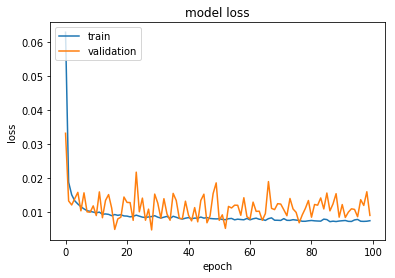

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,346.551336,380.064298,531.995269,0.88739,-0.63104,0.252243


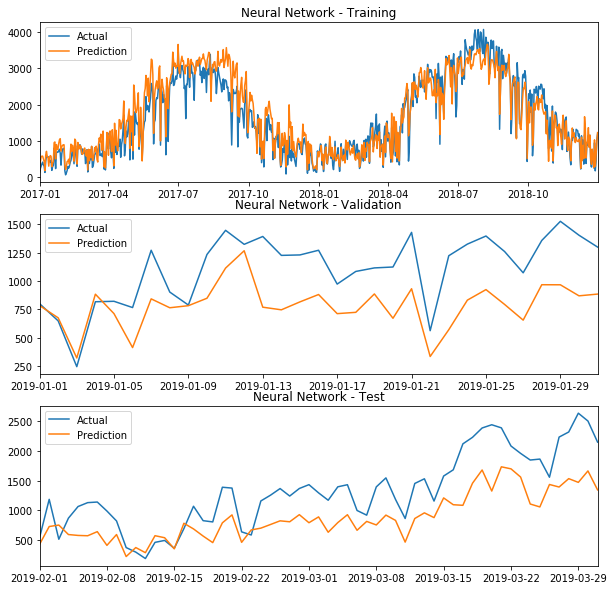

In [29]:
NN_y_pred_list = custom_predict(NN_model, X_train_NN_scaled, X_valid_NN_scaled, X_test_NN_scaled, y_scaler_NN)
y_pred_list = NN_y_pred_list
NN_score = custom_model_score(y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(NN_score))
custom_plot_package('Neural Network', y_pred_list, y_train, y_valid, y_test)

In [30]:
custom_score_display([lin_score, RF_score, XGB_score, LGBM_score, CB_score, NN_score], 
                     index=['Lin Reg', 'RF', 'XGB', 'LightGBM', 'CatBoost', 'Neural Network'])

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
Lin Reg,404.757259,421.274793,558.745766,0.846386,-1.003925,0.175153
RF,184.936772,397.622329,487.757633,0.967931,-0.785221,0.371431
XGB,236.069992,377.174598,493.899273,0.947746,-0.606332,0.355502
LightGBM,302.574415,386.498466,473.081048,0.914157,-0.686732,0.408689
CatBoost,478.564460,262.121124,375.746150,0.785256,0.224192,0.626978
Neural Network,346.551336,380.064298,531.995269,0.887390,-0.631040,0.252243


In [31]:
def predict_composition_model(index_list):
    
    '''
    Best model average
    '''
    
    output_df = []
    
    for i in range(3):
        out_y_predictors = pd.DataFrame({
                                'XGBoost': XGB_y_pred_list[i]*2,
                                #'Linear_Model': lin_reg_model_sm.predict(X_c_list[i]),
                                'CatBoost': CB_y_pred_list[i],
                                'Neural Network': NN_y_pred_list[i].reshape(1, NN_y_pred_list[i].shape[0])[0],
                                 })
        
        df_avg = pd.DataFrame({'Value': out_y_predictors.mean(axis=1)})
        df_avg.index = index_list[i]
        output_df.append(df_avg)
        
    return output_df

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,685.748165,199.586589,249.25183,0.55907,0.550207,0.835857


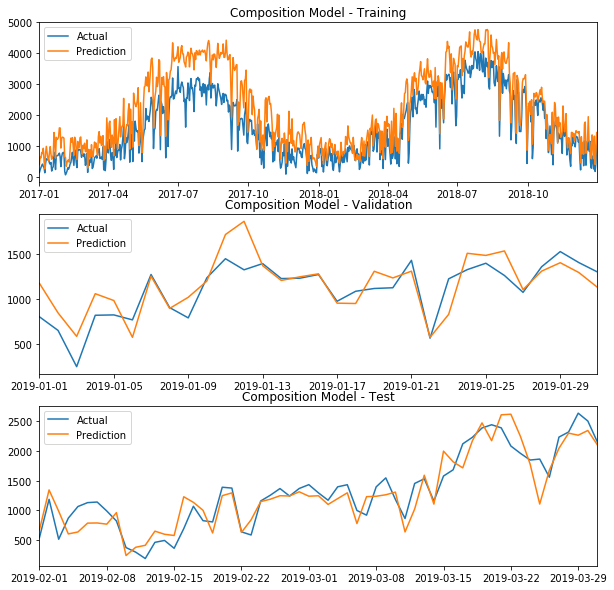

In [32]:
best_model_y_pred_list = predict_composition_model(index_list=[X_train.index, X_valid.index, X_test.index])
y_pred_list = best_model_y_pred_list

best_model_score = custom_model_score(y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(best_model_score))
custom_plot_package('Composition Model', y_pred_list, y_train, y_valid, y_test)

In [33]:
custom_score_display([lin_score, RF_score, XGB_score, LGBM_score, CB_score, NN_score, best_model_score], 
                     index=['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'Neural Network', 'Composition Model'])

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
Linear Regression,404.757259,421.274793,558.745766,0.846386,-1.003925,0.175153
Random Forest,184.936772,397.622329,487.757633,0.967931,-0.785221,0.371431
XGBoost,236.069992,377.174598,493.899273,0.947746,-0.606332,0.355502
LightGBM,302.574415,386.498466,473.081048,0.914157,-0.686732,0.408689
CatBoost,478.564460,262.121124,375.746150,0.785256,0.224192,0.626978
Neural Network,346.551336,380.064298,531.995269,0.887390,-0.631040,0.252243
Composition Model,685.748165,199.586589,249.251830,0.559070,0.550207,0.835857


In [34]:
from dateutil.relativedelta import *

output_score = []

start_date = datetime.date(2018, 1, 1)
end_date = datetime.date(2017, 12, 31)

for i in range(0,15):
    print(i)
    date_range_train = pd.date_range(start=datetime.date(2017, 1, 1), end=end_date, freq='D')
    date_range_valid = pd.date_range(start=start_date, end=(end_date + relativedelta(months=+1)), freq='D')
    date_range_test = pd.date_range(start=start_date, end=(end_date + relativedelta(months=+1)), freq='D')
                         
    start_date += relativedelta(months=+1)
    end_date += relativedelta(months=+1)
    
    X_onehot = pd.get_dummies(X)

    X_train = X_onehot.loc[date_range_train]
    X_valid = X_onehot.loc[date_range_valid]
    X_test = X_onehot.loc[date_range_test]

    y_train = y.loc[date_range_train]
    y_valid = y.loc[date_range_valid]
    y_test = y.loc[date_range_test]
    
    import statsmodels.api as sm
    X_onehot_c = sm.add_constant(X_onehot)

    X_train_c = X_onehot_c.loc[date_range_train]
    X_test_c = X_onehot_c.loc[date_range_test]
    X_valid_c = X_onehot_c.loc[date_range_valid]
    
    #=== Linear Regression
    lin_reg_model_sm = linear_model.OLS(y_train, X_train_c).fit()
    lin_y_pred_list = custom_predict(lin_reg_model_sm, X_train_c, X_valid_c, X_test_c)
    lin_score = custom_model_score(lin_y_pred_list, y_train, y_valid, y_test)
    
    #=== Random Forest
    RF_model.fit(X_train, y_train)
    RF_y_pred_list = custom_predict(RF_model, X_train, X_valid, X_test)
    RF_score = custom_model_score(RF_y_pred_list, y_train, y_valid, y_test)
    
    #=== XGBoost
    XGB_model.fit(X_train, y_train)
    XGB_y_pred_list = custom_predict(XGB_model, X_train, X_valid, X_test)
    XGB_score = custom_model_score(XGB_y_pred_list, y_train, y_valid, y_test)
    
    #=== LightGBM
    LGBM_model.fit(X_train, y_train)
    LGBM_y_pred_list = custom_predict(LGBM_model, X_train, X_valid, X_test)
    LGBM_score = custom_model_score(LGBM_y_pred_list, y_train, y_valid, y_test)
    
    #=== CatBoost
    CB_model.fit(X_train, y_train, verbose=False)
    CB_y_pred_list = custom_predict(CB_model, X_train, X_valid, X_test)
    CB_score = custom_model_score(CB_y_pred_list, y_train, y_valid, y_test)
    
    #=== Neural Network
    
    from sklearn.preprocessing import MinMaxScaler

    x_scaler_NN = MinMaxScaler()
    X_train_NN_scaled = x_scaler_NN.fit_transform(X_train)
    X_valid_NN_scaled = x_scaler_NN.transform(X_valid)
    X_test_NN_scaled = x_scaler_NN.transform(X_test)

    y_scaler_NN = MinMaxScaler()
    y_train_NN_scaled = y_scaler_NN.fit_transform(y_train.values.reshape(-1,1))
    y_valid_NN_scaled = y_scaler_NN.transform(y_valid.values.reshape(-1,1))
    y_test_NN_scaled = y_scaler_NN.transform(y_test.values.reshape(-1,1))
    
    history = NN_model.fit(X_train_NN_scaled, y_train_NN_scaled, epochs=100, verbose=0, batch_size=32, 
                       validation_data=(X_valid_NN_scaled, y_valid_NN_scaled), shuffle=True)

    NN_y_pred_list = custom_predict(NN_model, X_train_NN_scaled, X_valid_NN_scaled, X_test_NN_scaled, y_scaler_NN)
    NN_score = custom_model_score(NN_y_pred_list, y_train, y_valid, y_test)

    #===
    
    best_model_y_pred_list = predict_composition_model(index_list=[X_train.index, X_valid.index, X_test.index])
    best_model_score = custom_model_score(best_model_y_pred_list, y_train, y_valid, y_test)
    
    scores = custom_score_display([best_model_score, lin_score, RF_score, XGB_score, LGBM_score, CB_score, NN_score], 
                     index=['Composition Model', 'Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'Neural Network']).iloc[:,2]

    output_score.append(scores)

0


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:03:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


1


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:03:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:04:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


3


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:04:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


4


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:05:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


5


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:05:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


6


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:05:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


7


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:06:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


8


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:06:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


9


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:07:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


10


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:07:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


11


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:07:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


12


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:08:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


13


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:08:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


14


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:08:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


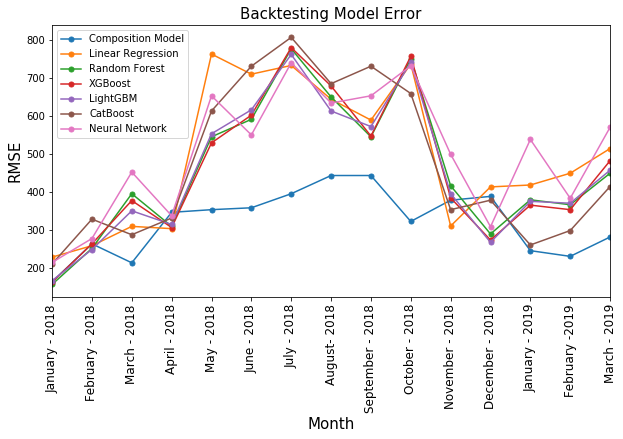

In [43]:
output = pd.concat(output_score, axis=1)
month_label = ['January - 2018', 'February - 2018', 'March - 2018', 'April - 2018', 'May - 2018', 'June - 2018', \
                  'July - 2018', 'August- 2018', 'September - 2018', 'October - 2018', 'November - 2018', 'December - 2018', \
                  'January - 2019', 'February -2019', 'March - 2019']

output.columns = month_label

font_size_tick = 12
ax = output.transpose().round().plot(figsize=(10,5), style='.-', markersize=10)
ax.set_xlabel('Month', size=15)
ax.set_ylabel('RMSE', size=15)
ax.set_title('Backtesting Model Error', size=15)
ax.set_xticks(range(0,len(month_label)), minor=False)
ax.set_xticklabels(month_label, fontsize=font_size_tick, rotation=90);

In [44]:
output.transpose().round()

,Composition Model,Linear Regression,Random Forest,XGBoost,LightGBM,CatBoost,Neural Network
January - 2018,163.0,228.0,156.0,162.0,166.0,210.0,214.0
February - 2018,263.0,258.0,251.0,263.0,248.0,328.0,277.0
March - 2018,213.0,309.0,395.0,377.0,350.0,287.0,452.0
April - 2018,346.0,303.0,309.0,306.0,314.0,331.0,337.0
May - 2018,353.0,763.0,545.0,529.0,553.0,613.0,653.0
June - 2018,358.0,710.0,591.0,602.0,616.0,731.0,550.0
July - 2018,395.0,733.0,777.0,780.0,762.0,807.0,740.0
August- 2018,443.0,644.0,650.0,679.0,613.0,685.0,634.0
September - 2018,443.0,589.0,545.0,547.0,572.0,731.0,653.0
October - 2018,322.0,737.0,751.0,757.0,741.0,659.0,732.0
